In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Output directory
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

# --------------------------
# Configurable constants
TEST_DAYS = 7
FORECAST_HORIZON = 7
MA_WINDOW = 7

DEFAULT_LEAD_TIME = 7       # days
SAFETY_FACTOR = 0.2         # 20% buffer
MIN_HISTORY_DAYS = 60

In [5]:
DATA_DIR = Path("data")

sales_df = pd.read_csv(DATA_DIR / "sales_orders.csv")
product_df = pd.read_csv(DATA_DIR / "product_master.csv")
stock_df = pd.read_csv(DATA_DIR / "stock_onhand.csv")

print("Rows loaded:")
print("Sales:", len(sales_df))
print("Products:", len(product_df))
print("Stock:", len(stock_df))

Rows loaded:
Sales: 7211
Products: 20
Stock: 1060


In [6]:
print(sales_df.columns.tolist())


['order_id', 'order_date', 'product_id', 'qty_ordered', 'customer_id']


In [7]:
# Load data
sales_df = pd.read_csv("data/sales_orders.csv")

# Standardize column names
sales_df.columns = sales_df.columns.str.strip().str.lower()

# Rename quantity column to a standard name
sales_df = sales_df.rename(columns={'qty_ordered': 'qty'})

# Validate required columns
required_sales_cols = ["product_id", "order_date", "qty"]
for col in required_sales_cols:
    if col not in sales_df.columns:
        raise ValueError(f"Missing required column in sales_orders.csv: {col}")

print("✅ Sales data validated successfully")


✅ Sales data validated successfully


In [8]:

# - Cleaning & daily aggregation

sales_df["order_date"] = pd.to_datetime(sales_df["order_date"], errors="coerce")
sales_df["qty"] = pd.to_numeric(sales_df["qty"], errors="coerce")

# Drop invalid rows
sales_df = sales_df.dropna(subset=["order_date", "qty"])
sales_df = sales_df[sales_df["qty"] > 0]

# Aggregate daily sales per product
sales_daily = (
    sales_df
    .groupby(["product_id", "order_date"], as_index=False)
    .agg(sales_qty=("qty", "sum"))
    .rename(columns={"order_date": "date"})
)

sales_daily = sales_daily.sort_values(["product_id", "date"])
print("Daily aggregated rows:", sales_daily.shape)


Daily aggregated rows: (7211, 3)


In [9]:
start_date = sales_daily["date"].min()
end_date = sales_daily["date"].max()

all_dates = pd.date_range(start_date, end_date, freq="D")
all_products = sales_daily["product_id"].unique()

calendar = pd.MultiIndex.from_product(
    [all_products, all_dates],
    names=["product_id", "date"]
).to_frame(index=False)

sales_full = (
    calendar
    .merge(sales_daily, on=["product_id", "date"], how="left")
)

sales_full["sales_qty"] = sales_full["sales_qty"].fillna(0)

sales_full = sales_full.sort_values(["product_id", "date"]).reset_index(drop=True)

sales_full.to_csv(OUT_DIR / "sales_daily_full.csv", index=False)
print("Saved sales_daily_full.csv")

Saved sales_daily_full.csv


In [10]:
# --------------------------
# Cell 5 - Feature engineering

def make_features(df):
    df = df.sort_values("date").copy()

    df["lag_1"] = df["sales_qty"].shift(1)
    df["lag_7"] = df["sales_qty"].shift(7)

    df["roll_mean_7"] = df["sales_qty"].shift(1).rolling(7).mean()
    df["roll_std_7"] = df["sales_qty"].shift(1).rolling(7).std()

    df["weekday"] = df["date"].dt.weekday
    df["month"] = df["date"].dt.month
    df["day_num"] = (df["date"] - df["date"].min()).dt.days

    return df.dropna().reset_index(drop=True)

sales_features = (
    sales_full
    .groupby("product_id", group_keys=False)
    .apply(make_features, include_groups=False)
    .reset_index()
)

print(sales_features.columns)


Index(['index', 'date', 'sales_qty', 'lag_1', 'lag_7', 'roll_mean_7',
       'roll_std_7', 'weekday', 'month', 'day_num'],
      dtype='object')


In [11]:
last_date = sales_full["date"].max()
forecast_rows = []

for pid in all_products:
    sub = sales_full[sales_full["product_id"] == pid]
    ma_value = sub["sales_qty"].rolling(MA_WINDOW).mean().iloc[-1]
    ma_value = max(0, round(ma_value))

    for i in range(1, FORECAST_HORIZON + 1):
        forecast_rows.append({
            "product_id": pid,
            "forecast_date": last_date + pd.Timedelta(days=i),
            "pred_qty": ma_value
        })

forecast_df = pd.DataFrame(forecast_rows)
forecast_df.to_csv(OUT_DIR / "forecast_ma7.csv", index=False)

print("Saved forecast_ma7.csv")

Saved forecast_ma7.csv


In [12]:
avg_demand = (
    sales_full
    .groupby("product_id")
    .tail(14)
    .groupby("product_id")["sales_qty"]
    .mean()
    .reset_index(name="avg_daily_14")
)

stock_df["snapshot_date"] = pd.to_datetime(stock_df["snapshot_date"], errors="coerce")
stock_df["onhand_qty"] = pd.to_numeric(stock_df["onhand_qty"], errors="coerce").fillna(0)

latest_stock = (
    stock_df
    .sort_values("snapshot_date")
    .groupby("product_id")
    .last()
    .reset_index()[["product_id", "onhand_qty"]]
)

plan = (
    product_df
    .merge(avg_demand, on="product_id", how="left")
    .merge(latest_stock, on="product_id", how="left")
)

plan["avg_daily_14"] = plan["avg_daily_14"].fillna(0)
plan["onhand_qty"] = plan["onhand_qty"].fillna(0)

In [13]:
plan["lead_time_days"] = DEFAULT_LEAD_TIME
plan["demand_during_lead"] = plan["avg_daily_14"] * plan["lead_time_days"]
plan["safety_stock"] = SAFETY_FACTOR * plan["demand_during_lead"]
plan["ROP"] = plan["demand_during_lead"] + plan["safety_stock"]

plan["suggested_order_qty"] = np.ceil(
    plan["ROP"] - plan["onhand_qty"]
).clip(lower=0).astype(int)

plan.to_csv(OUT_DIR / "reorder_plan.csv", index=False)
print("Saved reorder_plan.csv")

Saved reorder_plan.csv


In [14]:
#  Reorder logic

plan["lead_time_days"] = DEFAULT_LEAD_TIME
plan["demand_during_lead"] = plan["avg_daily_14"] * plan["lead_time_days"]
plan["safety_stock"] = SAFETY_FACTOR * plan["demand_during_lead"]
plan["ROP"] = plan["demand_during_lead"] + plan["safety_stock"]

plan["suggested_order_qty"] = np.ceil(
    plan["ROP"] - plan["onhand_qty"]
).clip(lower=0).astype(int)

plan.to_csv(OUT_DIR / "reorder_plan.csv", index=False)
print("Saved reorder_plan.csv")


Saved reorder_plan.csv


In [15]:
draft_po = plan[plan["suggested_order_qty"] > 0].copy()

draft_po["supplier_id"] = draft_po.get("supplier_id", "SUP_DEFAULT")
draft_po["product_qty"] = draft_po["suggested_order_qty"]
draft_po["scheduled_date"] = (
    pd.Timestamp.today().normalize()
    + pd.Timedelta(days=DEFAULT_LEAD_TIME)
)

draft_po = draft_po[[
    "supplier_id",
    "product_id",
    "product_name",
    "product_qty",
    "scheduled_date"
]]

draft_po.to_csv(OUT_DIR / "draft_purchase_orders.csv", index=False)
print("Saved draft_purchase_orders.csv")

Saved draft_purchase_orders.csv


In [16]:
print(sales_features.columns.tolist())

['index', 'date', 'sales_qty', 'lag_1', 'lag_7', 'roll_mean_7', 'roll_std_7', 'weekday', 'month', 'day_num']


In [17]:
print(sales_features.columns)

Index(['index', 'date', 'sales_qty', 'lag_1', 'lag_7', 'roll_mean_7',
       'roll_std_7', 'weekday', 'month', 'day_num'],
      dtype='object')


In [18]:
sales_features = sales_features.rename(columns={"index": "product_id"})

In [19]:
product_counts = sales_features["product_id"].value_counts()
print(product_counts.head())

product_id
0    20
1    20
2    20
3    20
4    20
Name: count, dtype: int64


In [20]:
pid = sales_features["product_id"].iloc[0]
sub = (
    sales_features[sales_features["product_id"] == pid]
    .sort_values("date")
    .reset_index(drop=True)
)

print("Rows for product:", len(sub))

Rows for product: 20


In [21]:
train = sub.iloc[:-TEST_DAYS]
test = sub.iloc[-TEST_DAYS:]

features = ["day_num", "lag_1", "roll_mean_7"]

X_train = train[features]
y_train = train["sales_qty"]
X_test = test[features]
y_test = test["sales_qty"]

print(X_train.shape, X_test.shape)



(13, 3) (7, 3)


In [22]:
print("Total rows in sub:", len(sub))
print("TEST_DAYS:", TEST_DAYS)


Total rows in sub: 20
TEST_DAYS: 7


In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)




In [24]:
print("Linear Regression Results")
print("MAE :", mean_absolute_error(y_test, pred_lr))



Linear Regression Results
MAE : 4.0694569450960865


In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, pred_lr))
print("RMSE:", rmse)

mape = np.mean(np.abs((y_test - pred_lr) / y_test)) * 100
print("MAPE:", round(mape, 2), "%")



RMSE: 6.361270443359008
MAPE: 36.86 %


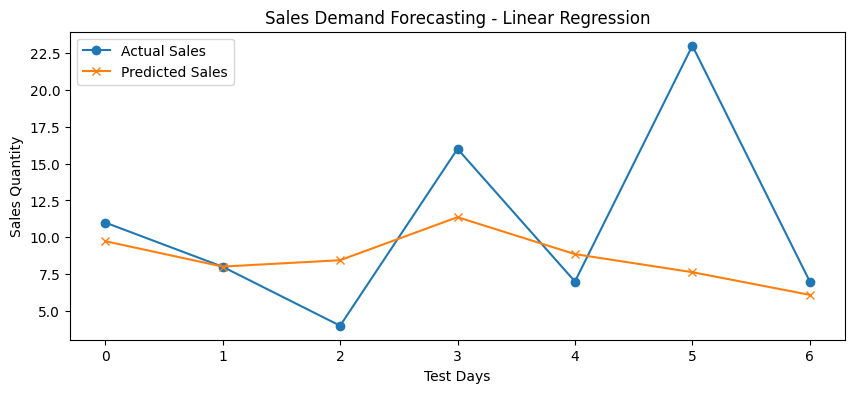

In [28]:
plt.figure(figsize=(10,4))
plt.plot(y_test.values, label="Actual Sales", marker='o')
plt.plot(pred_lr, label="Predicted Sales", marker='x')

plt.xlabel("Test Days")
plt.ylabel("Sales Quantity")
plt.legend()
plt.title("Sales Demand Forecasting - Linear Regression")
plt.show()

